<a href="https://colab.research.google.com/github/bensprecher/hello-world/blob/master/instacart_tf2_merge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import TensorFlow and other libraries

In [1]:
!pip install sklearn

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd

!pip install tensorflow==2.0.0-alpha0
import tensorflow as tf

# Load the TensorBoard notebook extension
%load_ext tensorboard.notebook
import datetime

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

     |████████████████████████████████| 79.9MB 526kB/s 
     |████████████████████████████████| 61kB 24.3MB/s 
     |████████████████████████████████| 3.0MB 36.0MB/s 
     |████████████████████████████████| 419kB 44.0MB/s 
  Found existing installation: tensorflow 1.13.1
    Uninstalling tensorflow-1.13.1:
      Successfully uninstalled tensorflow-1.13.1


In [0]:
# Clear any logs from previous runs for Tensorboard
!rm -rf ./logs/ 

# setup the log dir for Keras Model.fit() and the callback function
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


##Download the data

In [4]:
# Note - I'll be asked to authenticate into Google Drive and copy a code, then
# enter it below
from google.colab import auth
auth.authenticate_user()

# make data directory if it doesn't exist
import os
if not os.path.exists('./data'):
    print("Data dir didn't exist, creating it now...\n")
    os.makedirs('./data')

# Download the file(s) from my Google Cloud Storage bucket (-m flag means "in 
# parallel"). I previously downloaded the Instacart CSV files here.
# Moving them to a new directory, ./predict_next_purchase/data/
!gsutil -m cp gs://kaggle-holding-area/*.csv ./data/
  
# Print the result to make sure the transfer worked.
!ls ./data/*.csv
print("done!")

Data dir didn't exist, creating it now...

Copying gs://kaggle-holding-area/aisles.csv...
Copying gs://kaggle-holding-area/departments.csv...
Copying gs://kaggle-holding-area/sample_submission.csv...
Copying gs://kaggle-holding-area/order_products__train.csv...
Copying gs://kaggle-holding-area/orders.csv...
Copying gs://kaggle-holding-area/products.csv...
Copying gs://kaggle-holding-area/order_products__prior.csv...
/ [7/7 files][681.7 MiB/681.7 MiB] 100% Done                                    
Operation completed over 7 objects/681.7 MiB.                                    
./data/aisles.csv		  ./data/orders.csv
./data/departments.csv		  ./data/products.csv
./data/order_products__prior.csv  ./data/sample_submission.csv
./data/order_products__train.csv
done!


##Use Pandas to read and manipulate the CSV files as dataframes

In [5]:
# Data Exploration, copied from here: https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-instacart/notebook

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'


from subprocess import check_output
print(check_output(["ls", "data"]).decode("utf8"))


aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv
sample_submission.csv



Before we dive deep into the exploratory analysis, let us know a little more about the files given. To understand it better, let us first read all the files as dataframe objects and then look at the top few rows.

(Check out Pandas DataFrames here: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html)

In [0]:
order_products_train_df = pd.read_csv("data/order_products__train.csv")
order_products_prior_df = pd.read_csv("data/order_products__prior.csv")
orders_df = pd.read_csv("data/orders.csv")
products_df = pd.read_csv("data/products.csv")
aisles_df = pd.read_csv("data/aisles.csv")
departments_df = pd.read_csv("data/departments.csv")

How big are each of these files? Let's take a look at some data, and describe them.

In [7]:
print("order_products_train_df:", order_products_train_df.shape)
display(order_products_train_df.head())
display(order_products_train_df.describe())

print("order_products_prior_df:", order_products_prior_df.shape)
display(order_products_prior_df.head())
display(order_products_prior_df.describe())

print("orders_df:", orders_df.shape)
display(orders_df.head())
display(orders_df.describe())

print("products_df:", products_df.shape)
display(products_df.head())
display(products_df.describe())

print("aisles_df:", aisles_df.shape)
display(aisles_df.head())
display(aisles_df.describe())

print("departments_df:", departments_df.shape)
display(departments_df.head())
display(departments_df.describe())



order_products_train_df: (1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


,order_id,product_id,add_to_cart_order,reordered
count,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06
mean,1.706298e+06,2.555624e+04,8.758044e+00,5.985944e-01
std,9.897326e+05,1.412127e+04,7.423936e+00,4.901829e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.433700e+05,1.338000e+04,3.000000e+00,0.000000e+00
50%,1.701880e+06,2.529800e+04,7.000000e+00,1.000000e+00
75%,2.568023e+06,3.794000e+04,1.200000e+01,1.000000e+00
max,3.421070e+06,4.968800e+04,8.000000e+01,1.000000e+00


order_products_prior_df: (32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


,order_id,product_id,add_to_cart_order,reordered
count,3.243449e+07,3.243449e+07,3.243449e+07,3.243449e+07
mean,1.710749e+06,2.557634e+04,8.351076e+00,5.896975e-01
std,9.873007e+05,1.409669e+04,7.126671e+00,4.918886e-01
min,2.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.559430e+05,1.353000e+04,3.000000e+00,0.000000e+00
50%,1.711048e+06,2.525600e+04,6.000000e+00,1.000000e+00
75%,2.565514e+06,3.793500e+04,1.100000e+01,1.000000e+00
max,3.421083e+06,4.968800e+04,1.450000e+02,1.000000e+00


orders_df: (3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.214874e+06
mean,1.710542e+06,1.029782e+05,1.715486e+01,2.776219e+00,1.345202e+01,1.111484e+01
std,9.875817e+05,5.953372e+04,1.773316e+01,2.046829e+00,4.226088e+00,9.206737e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.552715e+05,5.139400e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.710542e+06,1.026890e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.565812e+06,1.543850e+05,2.300000e+01,5.000000e+00,1.600000e+01,1.500000e+01
max,3.421083e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01


products_df: (49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


,product_id,aisle_id,department_id
count,49688.000000,49688.000000,49688.000000
mean,24844.500000,67.769582,11.728687
std,14343.834425,38.316162,5.850410
min,1.000000,1.000000,1.000000
25%,12422.750000,35.000000,7.000000
50%,24844.500000,69.000000,13.000000
75%,37266.250000,100.000000,17.000000
max,49688.000000,134.000000,21.000000


aisles_df: (134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


,aisle_id
count,134.000000
mean,67.500000
std,38.826537
min,1.000000
25%,34.250000
50%,67.500000
75%,100.750000
max,134.000000


departments_df: (21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


,department_id
count,21.000000
mean,11.000000
std,6.204837
min,1.000000
25%,6.000000
50%,11.000000
75%,16.000000
max,21.000000


##clean up the Orders dataframe and add a column to flag first orders

In [8]:
# need a column to flag first orders since days_since_prior_order is NaN
orders_df["is_first_order"] = (orders_df["order_number"] == 1)

# normalize days_since_prior_order as "months_since_last_order" - max value is 30
# and replace NaNs with 0s (note, the df.loc command applies the mask to access)
# the values of the dataframe
orders_df["months_since_prior_order"] = orders_df["days_since_prior_order"]
orders_df.loc[orders_df["is_first_order"],"months_since_prior_order"] = 0 
orders_df["months_since_prior_order"] = orders_df["months_since_prior_order"]/30.0

# normalize order_number as order_sequence - max value is 100
orders_df["order_sequence"] = orders_df["order_number"]/100.0

# check to make sure the orders_df looks sensible
print("orders_df:", orders_df.shape)
display(orders_df.head())
display(orders_df.describe())
    
# # create a copy of the orders_df and sort it for processing
# cp_orders_df = pd.DataFrame()
# cp_orders_df = orders_df.copy()
# cp_orders_df.sort_values(by=['user_id', 'order_number'])
# #cp_orders_df.set_index("user_id", inplace=True) # we'll be indexing by user

# # dataframe for new columns
# new_orders_df = pd.DataFrame(columns=['user_ids','years_since_first_order','dow','did_this_user_order'])

# # now, build columns for user, dow, did_this_user_order, time
# for user in cp_orders_df['user_id'].unique():
#   # set up values for this user, 1 for each day of the year
#   user_ids[0:364] = user                 # categorical - this user
#   dow[0:364] = 0                         # categoryical - 0..6, the day of week
#   did_this_user_order[0:364] = False     # T/F - did user order this day?
#   last_order_day = 0                      # counter - reset to 0 for each user
#   for i in range(364):
#     years_since_first_order[i] = i/364.0  # scalar - 0..1; max of 1y per user 
#   #months_since_last_order[0:364] = 0.0   # scaler - 0..1; max of 30d b/t orders
  
#   # the orders for this user
#   this_users_sorted_orders_df = cp_orders_df.loc[cp_orders_df['user_id'] == user,
#                                                 ['order_number'],
#                                                 ['days_since_prior_order']].sort_values(by=['order_number'])
  
#   # then, fill out the dow with (1st dow + elapsed) MOD 7 (assuming we got the sort right)
#   assert this_users_sorted_orders_df['days_since_prior_order'][0] == "NaN"
#   for i in range(364):
#     dow[i] = (this_users_sorted_orders_df['order_dow'][0] + i) % 7
  
#   did_this_user_order[0] = True     # every user ordered on their 0th day
#   for order in range(1,this_users_sorted_orders_df['order_number'].len()-1):
#     # What's the next day the user ordered?
#     last_order_day += this_users_sorted_orders_df['days_since_prior_order'][order]
#     did_this_user_order[last_order_day] = True     # record that order
    
#   # now, dow[], did_this_user_order[], user_ids[], years_since_last_order[] are all set
#   # concat them to a new dataframe
#   new_orders_df = pd.concat(new_orders_df, pd.DataFrame(user_ids, years_since_first_order, dow, did_this_user_order))
  
# # check to make sure they look sensible
# print("this_users_sorted_orders_df:", this_users_sorted_orders_df.shape)
# display(this_users_sorted_orders_df.head())
# display(this_users_sorted_orders_df.describe())
  
# print("new_orders_df:", new_orders_df.shape)
# display(new_orders_df.head())
# display(new_orders_df.describe())




orders_df: (3421083, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,is_first_order,months_since_prior_order,order_sequence
0,2539329,1,prior,1,2,8,NaN,True,0.000000,0.01
1,2398795,1,prior,2,3,7,15.0,False,0.500000,0.02
2,473747,1,prior,3,3,12,21.0,False,0.700000,0.03
3,2254736,1,prior,4,4,7,29.0,False,0.966667,0.04
4,431534,1,prior,5,4,15,28.0,False,0.933333,0.05


,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,months_since_prior_order,order_sequence
count,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.214874e+06,3.421083e+06,3.421083e+06
mean,1.710542e+06,1.029782e+05,1.715486e+01,2.776219e+00,1.345202e+01,1.111484e+01,3.481626e-01,1.715486e-01
std,9.875817e+05,5.953372e+04,1.773316e+01,2.046829e+00,4.226088e+00,9.206737e+00,3.102909e-01,1.773316e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-02
25%,8.552715e+05,5.139400e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00,1.333333e-01,5.000000e-02
50%,1.710542e+06,1.026890e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00,2.333333e-01,1.100000e-01
75%,2.565812e+06,1.543850e+05,2.300000e+01,5.000000e+00,1.600000e+01,1.500000e+01,5.000000e-01,2.300000e-01
max,3.421083e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01,1.000000e+00,1.000000e+00


In [9]:
print(orders_df["eval_set"].value_counts())
print(orders_df["eval_set"].value_counts(normalize = True))

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64
prior    0.939724
train    0.038353
test     0.021923
Name: eval_set, dtype: float64


"Orders" table contains ~94% prior orders, 3.8% train and 2.2% test orders.

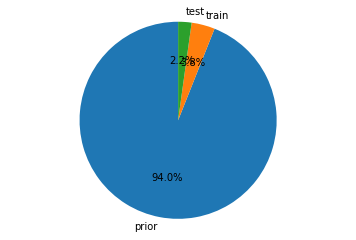

In [10]:
count = orders_df["eval_set"].value_counts()

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = count.index
sizes = count.values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

##Split the dataframe into train, validation, and test
The dataset we downloaded (and cleaned up) was a single CSV file. We will split this into train, validation, and test sets.

In [11]:
#train, test = train_test_split(dataframe, test_size=0.2)
#train, val = train_test_split(train, test_size=0.2)
train = orders_df.loc[orders_df['eval_set'] == "prior"]
val = orders_df.loc[orders_df['eval_set'] == "train"]
test = orders_df.loc[orders_df['eval_set'] == "test"]
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

3214874 train examples
131209 validation examples
75000 test examples


## Create an input pipeline using tf.data

Next, we will wrap the dataframes with [tf.data](https://www.tensorflow.org/guide/datasets). This will enable us  to use feature columns as a bridge to map from the columns in the Pandas dataframe to features used to train the model. If we were working with a very large CSV file (so large that it does not fit into memory), we would use tf.data to read it from disk directly. That is not covered in this tutorial.

In [0]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
# NOTE: MAY need to be updated since it was built for a different data set (heart data)
# assumes there is a column called "target" that needs to be popped off
def df_to_dataset(dataframe, shuffle=True, batch_size=32, target_col = 'target'):
  dataframe = dataframe.copy()
  labels = dataframe.pop(target_col)
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [0]:
batch_size = 5 # A small batch sized is used for demonstration purposes
#train_ds = df_to_dataset(orders_df, shuffle=False, batch_size=batch_size, target_col="days_since_prior_order")
train_ds = df_to_dataset(train, shuffle=False, batch_size=batch_size, target_col="months_since_prior_order")
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size, target_col="months_since_prior_order")
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size, target_col="months_since_prior_order")

## Understand the input pipeline

Now that we have created the input pipeline, let's call it to see the format of the data it returns. We have used a small batch size to keep the output readable.

In [14]:
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of order numbers:', feature_batch['order_sequence'])
  print('A batch of targets:', label_batch )

Every feature: ['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'is_first_order', 'order_sequence']
A batch of order numbers: tf.Tensor([0.01 0.02 0.03 0.04 0.05], shape=(5,), dtype=float64)
A batch of targets: tf.Tensor([0.         0.5        0.7        0.96666667 0.93333333], shape=(5,), dtype=float64)


We can see that the dataset returns a dictionary of column names (from the dataframe) that map to column values from rows in the dataframe.

##Demonstrate several types of feature columns
TensorFlow provides many types of feature columns. In this section, we will create several types of feature columns, and demonstrate how they transform a column from the dataframe.

In [0]:
# We will use this batch to demonstrate several types of feature columns
example_batch = next(iter(train_ds))[0]

# A utility method to create a feature column
# and to transform a batch of data
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

### Numeric columns
The output of a feature column becomes the input to the model (using the demo function defined above, we will be able to see exactly how each column from the dataframe is transformed). A [numeric column](https://www.tensorflow.org/api_docs/python/tf/feature_column/numeric_column) is the simplest type of column. It is used to represent real valued features. When using this column, your model will receive the column value from the dataframe unchanged.

In [16]:
oseq = feature_column.numeric_column("order_sequence")
demo(oseq)

W0510 03:22:02.587384 140304909846400 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/feature_column_v2.py:2758: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


[[0.01]
 [0.02]
 [0.03]
 [0.04]
 [0.05]]


## Choose which columns to use
We have seen how to use several types of feature columns. Now we will use them to train a model. The goal of this tutorial is to show you the complete code (e.g. mechanics) needed to work with feature columns. We have selected a few columns to train our model below arbitrarily.


In [0]:
feature_columns = []

# numeric cols
for header in ['order_sequence']:
  feature_columns.append(feature_column.numeric_column(header))
  
# ADD THIS BACK WHEN YOU CAN
# indicator cols
# first_order = feature_column.categorical_column_with_vocabulary_list(
#       'is_first_order', ['True', 'False'])
# first_order_one_hot = feature_column.indicator_column(first_order)
# feature_columns.append(first_order_one_hot)

# # indicator cols
dow = feature_column.categorical_column_with_identity('order_dow', 7)
dow_one_hot = feature_column.indicator_column(dow)
feature_columns.append(dow_one_hot)

# # embedding cols
# # 206k shoppers, 4th root = 21, so trying an embedding of 21
user_count = orders_df['user_id'].max()
user = feature_column.categorical_column_with_identity('user_id', user_count+1)
user_embedding = feature_column.embedding_column(user, dimension=21)
feature_columns.append(user_embedding)

# crossed cols (example from other notebook)
# crossed_feature = feature_column.crossed_column([age_buckets, thal], hash_bucket_size=1000)
# crossed_feature = feature_column.indicator_column(crossed_feature)
# feature_columns.append(crossed_feature)

### Create a feature layer
Now that we have defined our feature columns, we will use a [DenseFeatures](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/DenseFeatures) layer to input them to our Keras model.

In [0]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

Earlier, we used a small batch size to demonstrate how feature columns worked. We create a new input pipeline with a larger batch size.

In [0]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size, target_col="months_since_prior_order")
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size, target_col="months_since_prior_order")
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size, target_col="months_since_prior_order")

## Create, compile, and train the model

In [25]:
%tensorboard --logdir logs/fit


Reusing TensorBoard on port 6006 (pid 687), started 0:00:23 ago. (Use '!kill 687' to kill it.)

In [26]:
print(feature_columns)

[NumericColumn(key='order_sequence', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), IndicatorColumn(categorical_column=IdentityCategoricalColumn(key='order_dow', number_buckets=7, default_value=None)), EmbeddingColumn(categorical_column=IdentityCategoricalColumn(key='user_id', number_buckets=206210, default_value=None), dimension=21, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7f9b0bef7438>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True)]


In [1]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(64, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(1, activation='linear')
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error', 'mean_absolute_percentage_error'])

# note the added tensorboard callback
model.fit(train_ds,
          validation_data=val_ds,
          epochs=5,
          callbacks=[tensorboard_callback])

NameError: ignored

In [0]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

Key point: You will typically see best results with deep learning with much larger and more complex datasets. When working with a small dataset like this one, we recommend using a decision tree or random forest as a strong baseline. The goal of this tutorial is not to train an accurate model, but to demonstrate the mechanics of working with structured data, so you have code to use as a starting point when working with your own datasets in the future.

## Next steps
The best way to learn more about classifying structured data is to try it yourself. We suggest finding another dataset to work with, and training a model to classify it using code similar to the above. To improve accuracy, think carefully about which features to include in your model, and how they should be represented.



---



##Let's try to do some one-hot encoding of the orders-products

In [0]:
# what version is tensorflow?
print(tf.__version__)
!pip install tensorflow as tf
print(tf.__version__)

# what version is featurecolumns?
import tf.feature_columns as fc
print(fc.__version__)


In [0]:
# build a column of orders with sparsely encoded products per order
sparse_order_products_df = layers.sparse_column

In [0]:
# orders in prior, train sets
num_orders_prior = orders_df["eval_set"].value_counts()["prior"]
num_orders_train = orders_df["eval_set"].value_counts()["train"]
# hack this to make it small for now - memory issues otherwise
num_orders_prior = 20   # HACK
num_orders_train = 10   # HACK


# number of products --> dimensionality of 1-hot encoding
dimensionality = products_df.shape[0]

# largest basket across prior, train sets
max_length = order_products_prior_df["add_to_cart_order"].max()
max_length = max(max_length, order_products_train_df["add_to_cart_order"].max())

results_prior = np.zeros((num_orders_prior, max_length, dimensionality))
results_train = np.zeros((num_orders_train, max_length, dimensionality))

print(results_prior.shape)
print(results_train.shape)

# now I need to iterate the list of orders, and products per oder
# for i, order in enumerate(order_products_prior_df)
# print(orders_df.isin({'eval_set': ["prior"]}))


# Word2Vec on Instacart products
https://www.kaggle.com/omarito/word2vec-for-products-analysis-0-01-lb
### The goal of this kernel is to try a Word2Vec model on the data of product orders
### The orders can act as sentences and product ids can act as words, in this kernel we will see if the model will learn any useful information about the products from the order history of all users, maybe in the future this can be used as input to a classifier that recommends products.
## This gave me a slight increase in my LB score, so it's a useful feature
### Please upvote if you like it and let me know in the discussion if you have any remarks/ideas
### I also further explain the kernel in a blog post: http://omarito.me/word2vec-product-recommendations/

In [0]:
import pandas as pd
import numpy as np
!pip install gensim
import gensim
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

%matplotlib inline

### Load the Data

In [0]:
train_orders = pd.read_csv("data/order_products__train.csv")
prior_orders = pd.read_csv("data/order_products__prior.csv")
products = pd.read_csv("data/products.csv").set_index('product_id')

### Turn the product ID to a string
#### This is necessary because Gensim's Word2Vec expects sentences, so we have to resort to this dirty workaround

In [0]:
train_orders["product_id"] = train_orders["product_id"].astype(str)
prior_orders["product_id"] = prior_orders["product_id"].astype(str)

### Extract the ordered products in each order

In [0]:
# what do the training orders look like?
# display(train_orders.head(10))

In [0]:
train_products = train_orders.groupby("order_id").apply(lambda order: order['product_id'].tolist())
prior_products = prior_orders.groupby("order_id").apply(lambda order: order['product_id'].tolist())

# what do the training products look like?
display(train_products.head(10))

### Create the final sentences

In [0]:
sentences = prior_products.append(train_products)
longest = np.max(sentences.apply(len))
sentences = sentences.values
print(longest)

### Train Word2Vec model
#### I have modified the window size to be equal to the longest order in our dataset. I've explained why in a blog post that is further explaining this kernel in details
http://omarito.me/word2vec-product-recommendations/

--> Ben to do: add tensorboard visualizations

In [0]:
model = gensim.models.Word2Vec(sentences, size=100, window=longest, min_count=2, workers=4)

### Organize data for visualization

In [0]:
vocab = list(model.wv.vocab.keys())

### PCA transform the vectors into 2d

In [0]:
pca = PCA(n_components=2)
pca.fit(model.wv.syn0)

### Some helpers for visualization

In [0]:
def get_batch(vocab, model, n_batches=3):
    output = list()
    for i in range(0, n_batches):
        rand_int = np.random.randint(len(vocab), size=1)[0]
        suggestions = model.most_similar(positive=[vocab[rand_int]], topn=5)
        suggest = list()
        for i in suggestions:
            suggest.append(i[0])
        output += suggest
        output.append(vocab[rand_int])
    return output

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    """From Tensorflow's tutorial."""
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
#     plt.savefig(filename)
    plt.show()

### Visualize a random sample

In [0]:
embeds = []
labels = []
for item in get_batch(vocab, model, n_batches=3):
    embeds.append(model[item])
    labels.append(products.loc[int(item)]['product_name'])
embeds = np.array(embeds)
embeds = pca.fit_transform(embeds)
plot_with_labels(embeds, labels)


### Save the model

In [0]:
model.save("product2vec.model")

# ToDo


*   Calculate F1 Score: https://www.kaggle.com/hongweizhang/how-to-calculate-f1-score
*   Some interesting charting: https://www.kaggle.com/shwong/the-instacart-chart
*   Connect to Facets: https://github.com/PAIR-code/facets, https://pair-code.github.io/facets/
*   Basic data visualization: https://www.kaggle.com/banivyom/data-visualization/code
*   Interesting features in BigQuery (including getting the data imported there): https://www.kaggle.com/tkm2261/my-15th-solution-features-mainly-using-bigquery
*   More data viz: https://www.kaggle.com/frednavruzov/instacart-exploratory-data-analysis/code
*   simple data viz: https://www.kaggle.com/serigne/instacart-simple-data-exploration/code
*   Exploratory Data Analysis and Word2Vec for similar products: https://www.kaggle.com/ipsitp/eda-tie-outs-and-finding-similar-products/code
*   Matplotlib documentation: https://matplotlib.org/index.html
*   List item














